## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

display(df.info())
display(df.head(10))

print(
      'Data is monotonic -', 
      df.index.is_monotonic
)
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Data is monotonic - True


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


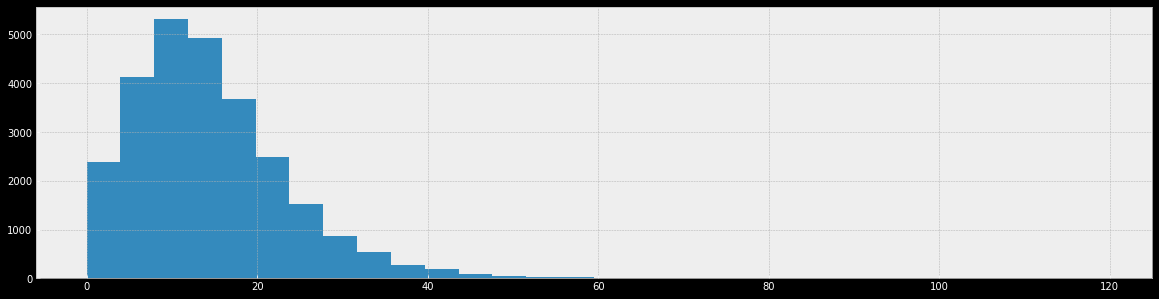

In [4]:
plt.style.use('dark_background')
plt.style.use('bmh')
df['num_orders'].hist(bins=30, figsize=(20, 5))
plt.show()

### Общий обзор данных

В таблице 2 столбца - в одном указана дата заказов с интервалом в десять минут, в другом количество заказов в течение этого интервала. Даты расположены в хронологиечском порядке. Типы приведены к нужным. Предобработка не требуется. Математическое описание показало, что в среднем за 10 минут происходит **14** заказов, медиана равна **13**, а максимальное значение равно **119**. Стандартное отклонение равняется **9**. Гистограмма показало, что значения распределены нормально, аномальными значениями можно считать те, что больше **40**. Проведем анализ временных рядов. 

In [5]:
f"Временной промежуток данных: {df.index.min()} - {df.index.max()}"

'Временной промежуток данных: 2018-03-01 00:00:00 - 2018-08-31 23:50:00'

In [6]:
df = df.resample('1H').sum()

## Анализ

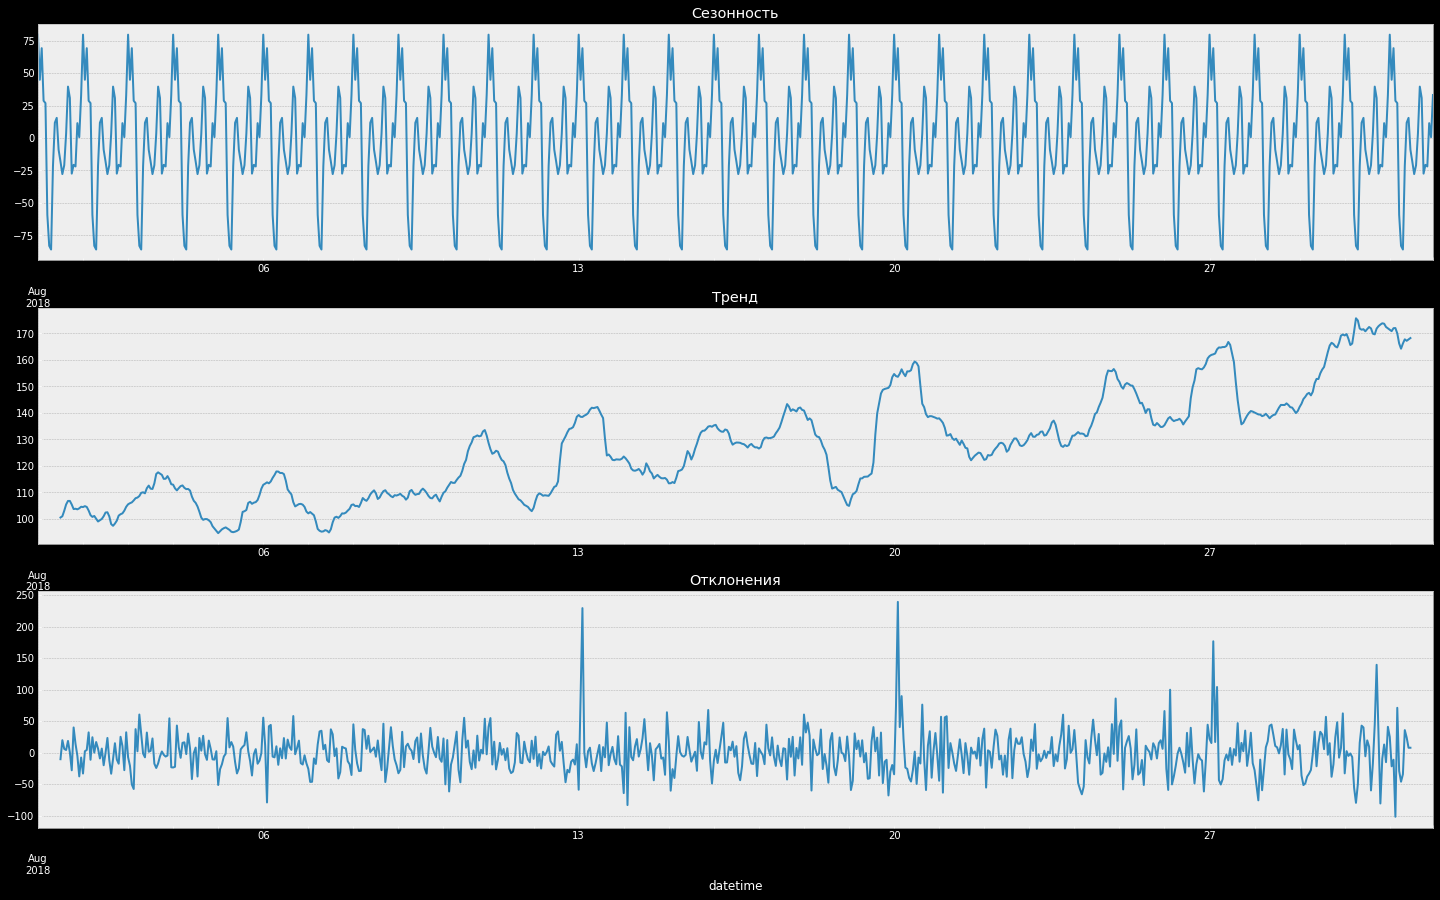

In [7]:
decomposed = seasonal_decompose(df['2018-08':'2018-08'])
plt.figure(figsize=(25, 20))

plt.subplot(411)
decomposed.seasonal.plot()
plt.title('Сезонность')

plt.subplot(412)
decomposed.trend.plot()
plt.title('Тренд')

plt.subplot(413)
decomposed.resid.plot()
plt.title('Отклонения')

plt.show()

Распределение в сезонности статическое. Количество заказов имеет одинаковый рост с утра до вечера каждый день, ночью падает. Тренд на увеличение заказов со временем. Отклонения равномерны, заисключением нескольких выбросов, которые можно объяснить различными мероприятиями. Посмотрим на общий статистику за полгода. 

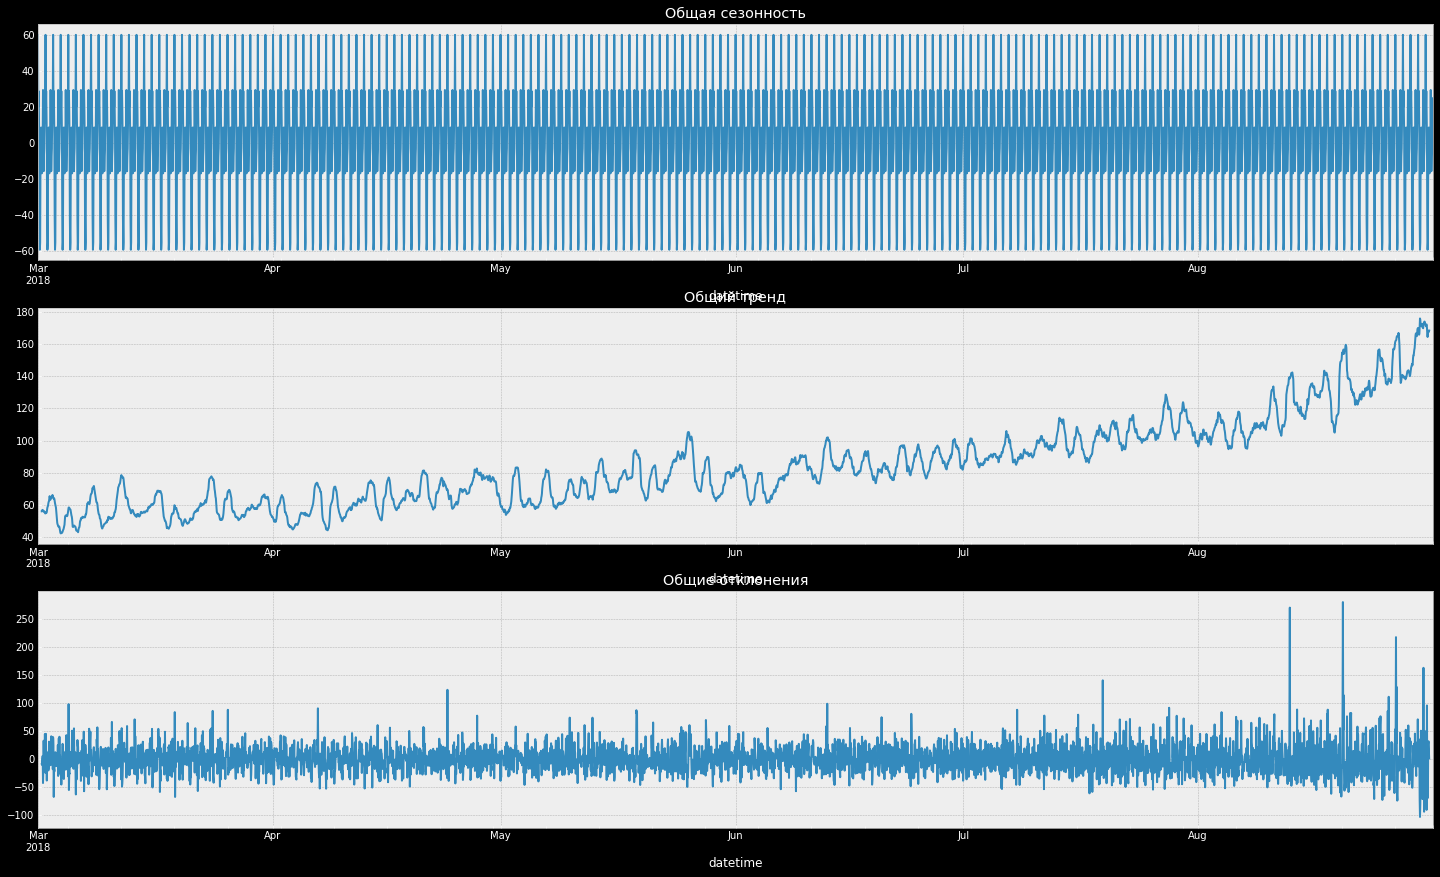

In [8]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(25, 20))

plt.subplot(411)
decomposed.seasonal.plot()
plt.title('Общая сезонность')

plt.subplot(412)
decomposed.trend.plot()
plt.title('Общий тренд')

plt.subplot(413)
decomposed.resid.plot()
plt.title('Общие отклонения')

plt.show()

Видим, что общие сезонность не меняется, тренд на заказы такси за полгода повышается, количество отклонений увеличивается в августе.

## Обучение и тестирование

Моделью заглушкой предскажем новые значения предыдущими. 

In [21]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse_base =  mean_squared_error(test['num_orders'], pred_previous) ** 0.5
print("RMSE baseline модели:", round(rmse_base, 3))

RMSE baseline модели: 58.856


Сделаем предсказания посреднему значению. 

In [10]:
pred_mean = np.ones(test.shape) * train['num_orders'].mean()
print("RMSE baseline модели:", mean_squared_error(test['num_orders'], pred_mean) ** 0.5)

RMSE baseline модели: 84.74414402014742


Предсказания по предыдущему значению показывают лучший результат. Возьмём их в качестве заглушки.

Напишем функцию для создания обучающих признаков. Создадим признаки **day, dayofweek**. А также признаки для скользящего среднего **rolling_mean** (с размером окна rolling_mean_size), и **lag_i** для признаков отстающего значения.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

In [12]:
df_mf = make_features(df, 30, 50)

#### Линейная регрессия

In [13]:
train, test = train_test_split(df_mf, shuffle=False, test_size=0.1)
train = train.dropna()

In [14]:
train.head(10)

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,5,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,...,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,62.82
2018-03-03 03:00:00,64,5,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,60.84
2018-03-03 04:00:00,44,5,64.0,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,60.42
2018-03-03 05:00:00,15,5,44.0,64.0,25.0,108.0,163.0,72.0,119.0,101.0,...,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,59.88
2018-03-03 06:00:00,9,5,15.0,44.0,64.0,25.0,108.0,163.0,72.0,119.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.86
2018-03-03 07:00:00,17,5,9.0,15.0,44.0,64.0,25.0,108.0,163.0,72.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,58.18
2018-03-03 08:00:00,56,5,17.0,9.0,15.0,44.0,64.0,25.0,108.0,163.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,58.40
2018-03-03 09:00:00,73,5,56.0,17.0,9.0,15.0,44.0,64.0,25.0,108.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,59.28
2018-03-03 10:00:00,52,5,73.0,56.0,17.0,9.0,15.0,44.0,64.0,25.0,...,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,60.44


In [15]:
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

lm = LinearRegression()
lm.fit(X_train, y_train)
preds_train = lm.predict(X_train)
print("RMSE на обучающей выборке:", mean_squared_error(y_train, preds_train) ** 0.5)

preds_test = lm.predict(X_test)
print("RMSE на тестовой выборке: ", mean_squared_error(y_test, preds_test) ** 0.5)

RMSE на обучающей выборке: 25.346573606609045
RMSE на тестовой выборке:  44.60829750078014


Сделаем подбор точных параметров. 

In [16]:
%%time
best_lag_lm = 0
best_roll_size_lm = 0
best_rmse_lm = 48
for lag in range(1, 101, 5):
    for roll_size in range(1, 101, 5):

        data = make_features(df, lag, roll_size)
        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        tscv = TimeSeriesSplit()
        train = train.dropna()
        X_train = train.drop('num_orders', axis = 1)
        y_train = train['num_orders']

        lm = LinearRegression()
        lm.fit(X_train, y_train)

        preds_train = lm.predict(X_train)
        rmse = mean_squared_error(y_train, preds_train) ** 0.5
        cross_val = cross_val_score(lm, X_train, y_train, cv=tscv).mean()
        if rmse < best_rmse_lm :
            best_rmse_lm = rmse
            best_lag_lm = lag
            best_roll_size_lm = roll_size
            best_cross_val_lm = cross_val
            
print(f"RMSE на тренировочной выборке: {best_rmse_lm}, максимальное смещение {best_lag_lm}, размер скользящего окна {best_roll_size_lm}, cross val {best_cross_val_lm}")

RMSE на тренировочной выборке: 22.283425608355014, максимальное смещение 96, размер скользящего окна 16, cross val 0.54214358479726
CPU times: user 4min 21s, sys: 54.9 s, total: 5min 16s
Wall time: 46.2 s


#### Модель Lasso и Ridge

Обучим модели регуляризацией. 

In [17]:
def model_build(model):
    best_lag = 0
    best_roll_size = 0
    best_alpha = 0
    best_rmse = 48
    for lag in range(1, 101, 5):
        for roll_size in range(1, 101, 5):
            for alpha in np.arange(0.1, 1, 0.2):

                data = make_features(df, lag, roll_size)
                train, test = train_test_split(data, shuffle=False, test_size=0.1)
                train = train.dropna()
                X_train = train.drop('num_orders', axis = 1)
                y_train = train['num_orders']
              
                
                if model == 'Lasso' :
                    lm = Lasso(alpha=alpha)
                elif model == 'Ridge' :
                    lm = Ridge(alpha=alpha)
                lm.fit(X_train, y_train)

                preds_train = lm.predict(X_train)
                rmse = mean_squared_error(y_train, preds_train) ** 0.5
                cross_val = cross_val_score(lm, X_train, y_train, cv=tscv).mean()
                if rmse < best_rmse :
                    best_rmse = rmse
                    best_lag = lag
                    best_roll_size = roll_size
                    best_alpha = alpha
                    best_cross_val = cross_val
                    
    return best_rmse, best_lag, best_roll_size, best_alpha, best_cross_val

In [18]:
%%time
best_rmse_ls, best_lag_ls, best_roll_size_ls, best_alpha_ls, best_cross_val_ls = model_build("Lasso")
print(f"===== Модель Lasso =====")
print(f"RMSE на тестовой выборке: {best_rmse_ls}, максимальное смещение {best_lag_ls}, размер скользящего окна {best_roll_size_ls}, cross val {best_cross_val_ls}")
print(f"Коэффициент регуляризации: {best_alpha_ls}")

===== Модель Lasso =====
RMSE на тестовой выборке: 22.283546308052003, максимальное смещение 96, размер скользящего окна 76, cross val 0.5426038521549195
Коэффициент регуляризации: 0.1
CPU times: user 41min 20s, sys: 9min 14s, total: 50min 35s
Wall time: 8min 47s


In [19]:
%%time
best_rmse_rg, best_lag_rg, best_roll_size_rg, best_alpha_rg, best_cross_val_rg = model_build("Ridge")
print(f"===== Модель Ridge =====")
print(f"RMSE на тестовой выборке: {best_rmse_rg}, максимальное смещение {best_lag_rg}, размер скользящего окна {best_roll_size_rg}, cross val {best_cross_val_rg}")
print(f"Коэффициент регуляризации: {best_alpha_rg}")

===== Модель Ridge =====
RMSE на тестовой выборке: 22.283425608355625, максимальное смещение 96, размер скользящего окна 1, cross val 0.5421395147289276
Коэффициент регуляризации: 0.1
CPU times: user 16min 19s, sys: 3min 17s, total: 19min 36s
Wall time: 3min 30s


## Подведение итогов

В предыдущем пункте мы уже сделали тестирование, поэтому здесь моберем данные о моделях в одном месте и подведем итоги. 

In [22]:
stats = pd.DataFrame([['Baseline', round(rmse_base, 3), 1, 0, np.nan, np.nan],
                      ['Linear Regression', round(best_rmse_lm, 3), best_lag_lm, best_roll_size_lm, np.nan, best_cross_val_lm],
                      ['Lasso', round(best_rmse_ls, 3), best_lag_ls, best_roll_size_ls, best_alpha_ls, best_cross_val_ls],
                      ['Ridge', round(best_rmse_rg, 3), best_lag_rg, best_roll_size_rg, best_alpha_rg, best_cross_val_rg]],
                    columns = ['model', 'rmse', 'max_lag', 'roll_size', 'alpha', 'cross_val'])

In [23]:
stats

,model,rmse,max_lag,roll_size,alpha,cross_val
0,Baseline,58.856,1,0,NaN,NaN
1,Linear Regression,22.283,96,16,NaN,0.542144
2,Lasso,22.284,96,76,0.1,0.542604
3,Ridge,22.283,96,1,0.1,0.542140


Протестируем модель LinearRegression.

In [27]:
df = make_features(df, 96, 16)
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

linear = LinearRegression()
linear.fit(X_train, y_train)
preds_test = pd.Series(linear.predict(X_test), index = y_test.index, name='preds')

Объеденим данные в таблицу, чтобы построить по ним график.

In [28]:
df_preds = pd.concat([y_test, preds_test], axis=1)
df_preds.head(10)

,num_orders,preds
datetime,,
2018-08-13 14:00:00,102,126.454673
2018-08-13 15:00:00,175,135.305004
2018-08-13 16:00:00,144,162.875784
2018-08-13 17:00:00,152,129.835004
2018-08-13 18:00:00,104,105.942403
2018-08-13 19:00:00,91,101.175931
2018-08-13 20:00:00,82,82.996587
2018-08-13 21:00:00,160,129.677032
2018-08-13 22:00:00,104,132.522524


Построим график по предсказаниям за последние 2 недели. 

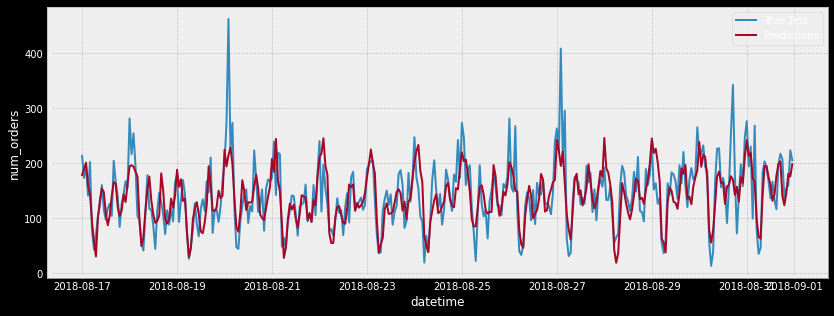

In [29]:
plt.figure(figsize=(14, 5))
plt.style.use('dark_background')
plt.style.use('bmh')
data = df_preds['2018-08-17':]
sns.lineplot(x=data.index, y=data['num_orders'], label='True Test')
sns.lineplot(x=data.index, y=data['preds'], label='Predictions')
plt.show()

##### Вывод

На графике видим, что модель показала хорошие результаты.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48